In [154]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree,DecisionTreeRegressor
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score

In [155]:
survey_data_path = 'data/survey_data.csv'
song_features_path = 'data/song_features.csv'

# Load survey data and concatenate with song features

In [156]:
df = pd.read_csv(survey_data_path)
song_features = pd.read_csv(song_features_path)

df = pd.concat([df, song_features], axis=1)

df['mental_positive'] = np.where(df['positive_mean'] - df['negative_mean'] > 0, 1, 0)

df.drop(columns=['positive_mean', 'negative_mean'], inplace=True)

df.head()

,Unnamed: 0,time,age,gender,hours_per_day,genres,change_mood,music_type,song_num,song,...,Song,Danceability,Energy,Valence,Acousticness,Instrumentalness,Tempo,Key,Speechiness,mental_positive
0,0,4/4/2025 0:09:15,22,Male,1-2 hours,"Pop 🎶, Classical 🎻, Jazz 🎷",Yes,Music that matches my mood,song_1,Under a blanket of blue - Ella Firzgerald & Lo...,...,Under a blanket of blue - Ella Firzgerald & Lo...,0.28,0.21,0.68,0.92,0.05,72.4,5,0.04,1
1,1,4/4/2025 0:09:40,22,Male,1-2 hours,"Pop 🎶, Hip-Hop/Rap 🎤, Electronic/Dance 🧑‍🎤",No,I don't listen to music when feeling down,song_1,ผิงไฟ - Max Jenmana,...,ผิงไฟ - Max Jenmana,0.42,0.38,0.61,0.85,0.12,98.6,7,0.03,1
2,2,4/4/2025 0:11:42,21,Male,Less than 1 hour,"Pop 🎶, Hip-Hop/Rap 🎤, Metal 👨‍🎤",No,I don't listen to music when feeling down,song_1,ใจพัง -Saran,...,ใจพัง -Saran,0.56,0.74,0.22,0.31,0.02,126.8,9,0.06,1
3,3,4/4/2025 0:14:05,22,Female,1-2 hours,"Pop 🎶, Rock 🎸, Electronic/Dance 🧑‍🎤, Others",Yes,Music that matches my mood,song_1,Denial is a river - Doechi,...,Denial is a river - Doechi,0.77,0.68,0.48,0.18,0.02,139.2,1,0.18,1
4,4,4/4/2025 0:58:36,20,Female,1-2 hours,"Rock 🎸, Hip-Hop/Rap 🎤, Electronic/Dance 🧑‍🎤, O...",Yes,Music that contrasts with my mood,song_1,She’s gone Dance on de Disclosure,...,She's gone Dance on de Disclosure,0.85,0.81,0.63,0.12,0.08,124.3,10,0.05,1


In [157]:
# Remove rows with music_type = "I don't listen to music when feeling down"

df = df[df['music_type'] != "I don't listen to music when feeling down"]

# Reverse rows with music_type = "Music that contrasts with my mood"

df['mental_positive'] = np.where(df['music_type'] == "Music that contrasts with my mood", 1 - df['mental_positive'], df['mental_positive'])

In [158]:
# Create binary genre columns
genres_columns = ['pop', 'rock', 'hip-hop/rap', 'country', 'classical', 'jazz', 'folk', 'metal', 'electronic/dance', 'others']

for genre in genres_columns:
    if genre == 'hip-hop/rap':
        df[genre] = df['genres'].apply(lambda x: 1 if any(g in x.lower() for g in ['hip-hop', 'hip hop', 'rap']) else 0)
    elif genre == 'electronic/dance':
        df[genre] = df['genres'].apply(lambda x: 1 if any(g in x.lower() for g in ['electronic', 'dance']) else 0)
    else:
        df[genre] = df['genres'].apply(lambda x: 1 if genre.lower() in x.lower() else 0)

In [159]:
# Convert categorical variables to numerical
# One-hot encode gender instead of binary mapping
gender_dummies = pd.get_dummies(df['gender'], prefix='gender', dtype=int)
df = pd.concat([df, gender_dummies], axis=1)

df['change_mood'] = df['change_mood'].map({'Yes': 1, 'No': 0})

# One-hot encode hours_per_day and music_type
df = pd.concat([df, pd.get_dummies(df['hours_per_day'], dtype=int)], axis=1)

# Create binary columns for music type preferences
for value, suffix in {'Music that matches my mood': 'matches_mood',
                      "I don't listen to music when feeling down": 'no_music_when_down',
                      'Music that contrasts with my mood': 'contrasts_mood',
                      'Both': 'both'}.items():
    df[f'music_type_{suffix}'] = (df['music_type'] == value).astype(int)

# Remove unnecessary columns
columns_to_drop = [
    'Unnamed: 0', 'time', 'genres', 'song', 'song_num', 'title_1', 'author_1',
    'interested', 'distressed', 'excited', 'upset', 'enthusiastic', 'nervous',
    'proud', 'afraid', 'inspired', 'irritable',
    'hours_per_day', 'music_type', 'music_type_no_music_when_down', 'gender'
]
df.drop(columns=columns_to_drop, inplace=True)

In [160]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,300.0,22.170000,5.044395,16.00,20.0000,21.00,22.000,55.00
change_mood,300.0,0.720000,0.449749,0.00,0.0000,1.00,1.000,1.00
Danceability,300.0,0.654933,0.136000,0.15,0.5800,0.68,0.760,0.88
Energy,300.0,0.699900,0.138362,0.21,0.6275,0.72,0.780,0.98
Valence,300.0,0.583433,0.149409,0.24,0.4600,0.62,0.680,0.96
Acousticness,300.0,0.335200,0.225982,0.03,0.1775,0.26,0.420,0.94
Instrumentalness,300.0,0.064733,0.163906,0.00,0.0000,0.01,0.030,0.94
Tempo,300.0,120.035333,15.556135,69.20,112.6000,124.60,128.425,186.40
Key,300.0,5.693333,3.021543,0.00,3.0000,6.00,8.000,11.00
Speechiness,300.0,0.082933,0.060611,0.02,0.0500,0.06,0.080,0.32


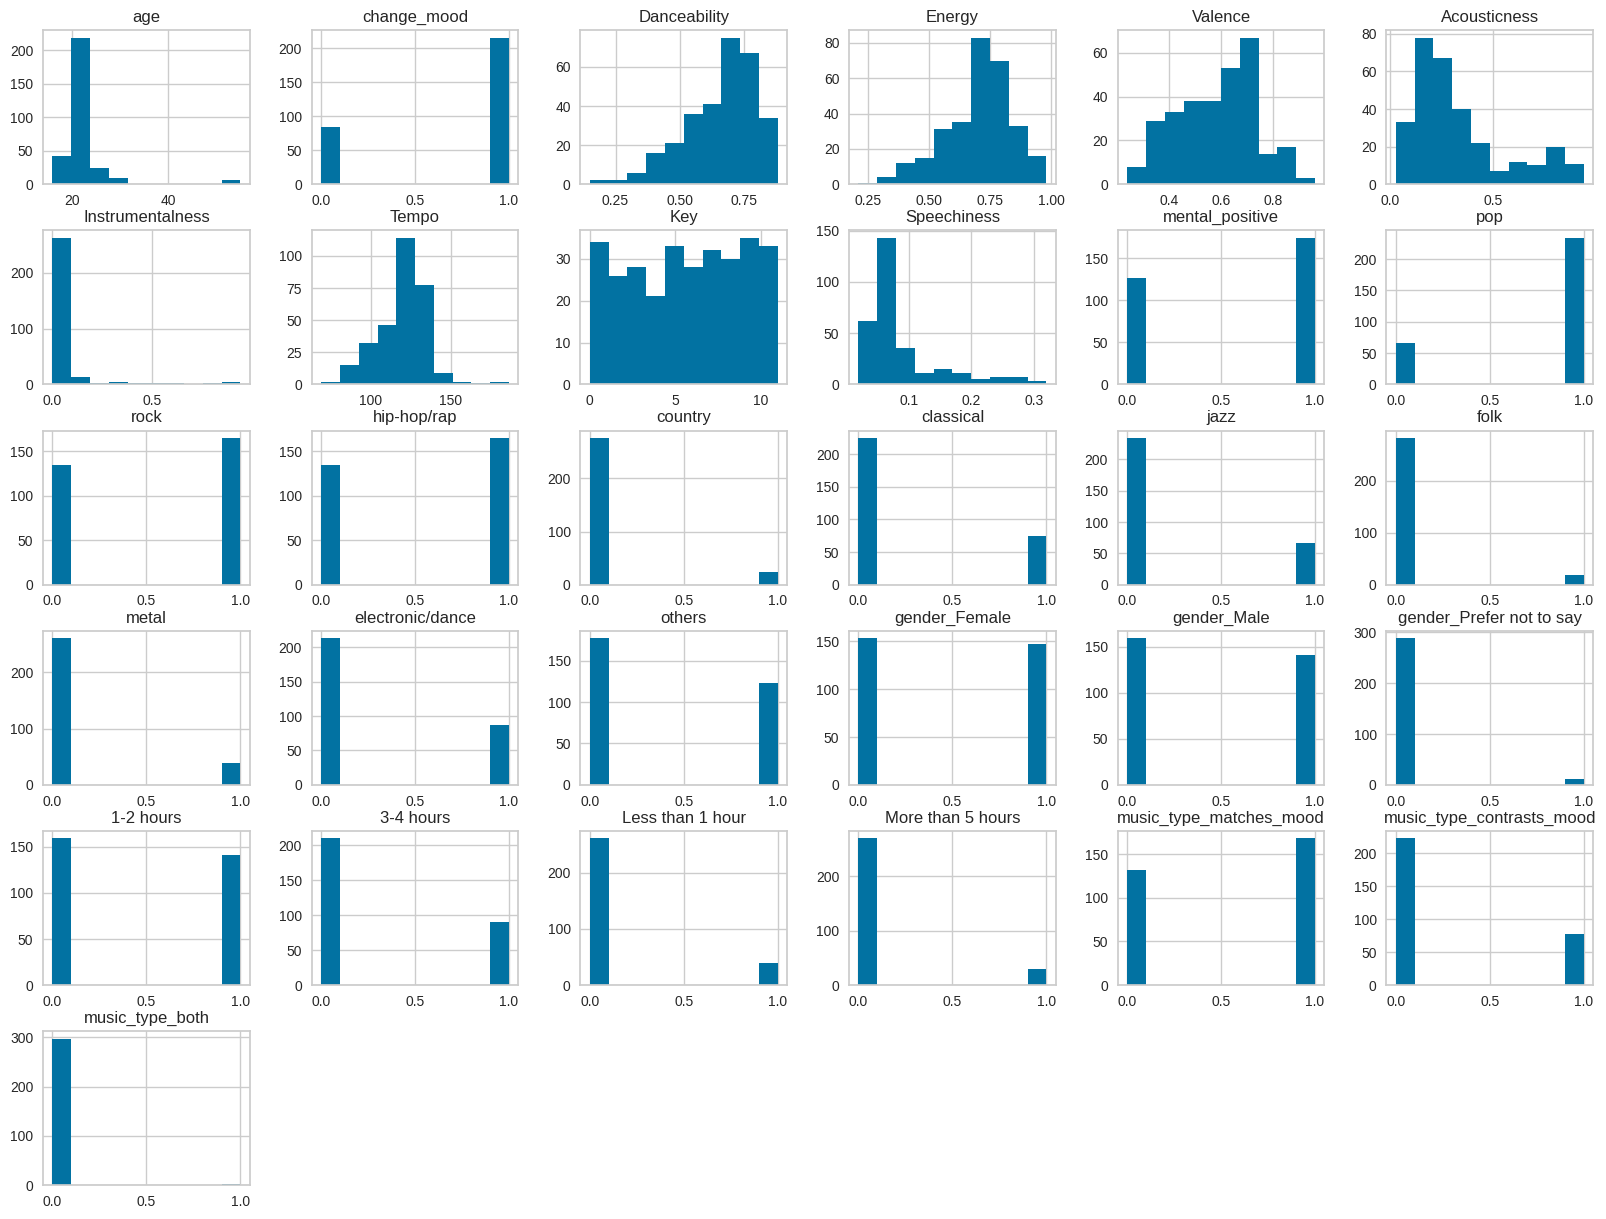

In [161]:
df.hist(figsize=(20, 15))
plt.show()

# Preprocess data

In [162]:
df.isna().sum()

,0
age,0
change_mood,0
Song,0
Danceability,0
Energy,0
Valence,0
Acousticness,0
Instrumentalness,0
Tempo,0
Key,0


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 326
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        300 non-null    int64  
 1   change_mood                300 non-null    int64  
 2   Song                       300 non-null    object 
 3   Danceability               300 non-null    float64
 4   Energy                     300 non-null    float64
 5   Valence                    300 non-null    float64
 6   Acousticness               300 non-null    float64
 7   Instrumentalness           300 non-null    float64
 8   Tempo                      300 non-null    float64
 9   Key                        300 non-null    int64  
 10  Speechiness                300 non-null    float64
 11  mental_positive            300 non-null    int64  
 12  pop                        300 non-null    int64  
 13  rock                       300 non-null    int64  
 14 

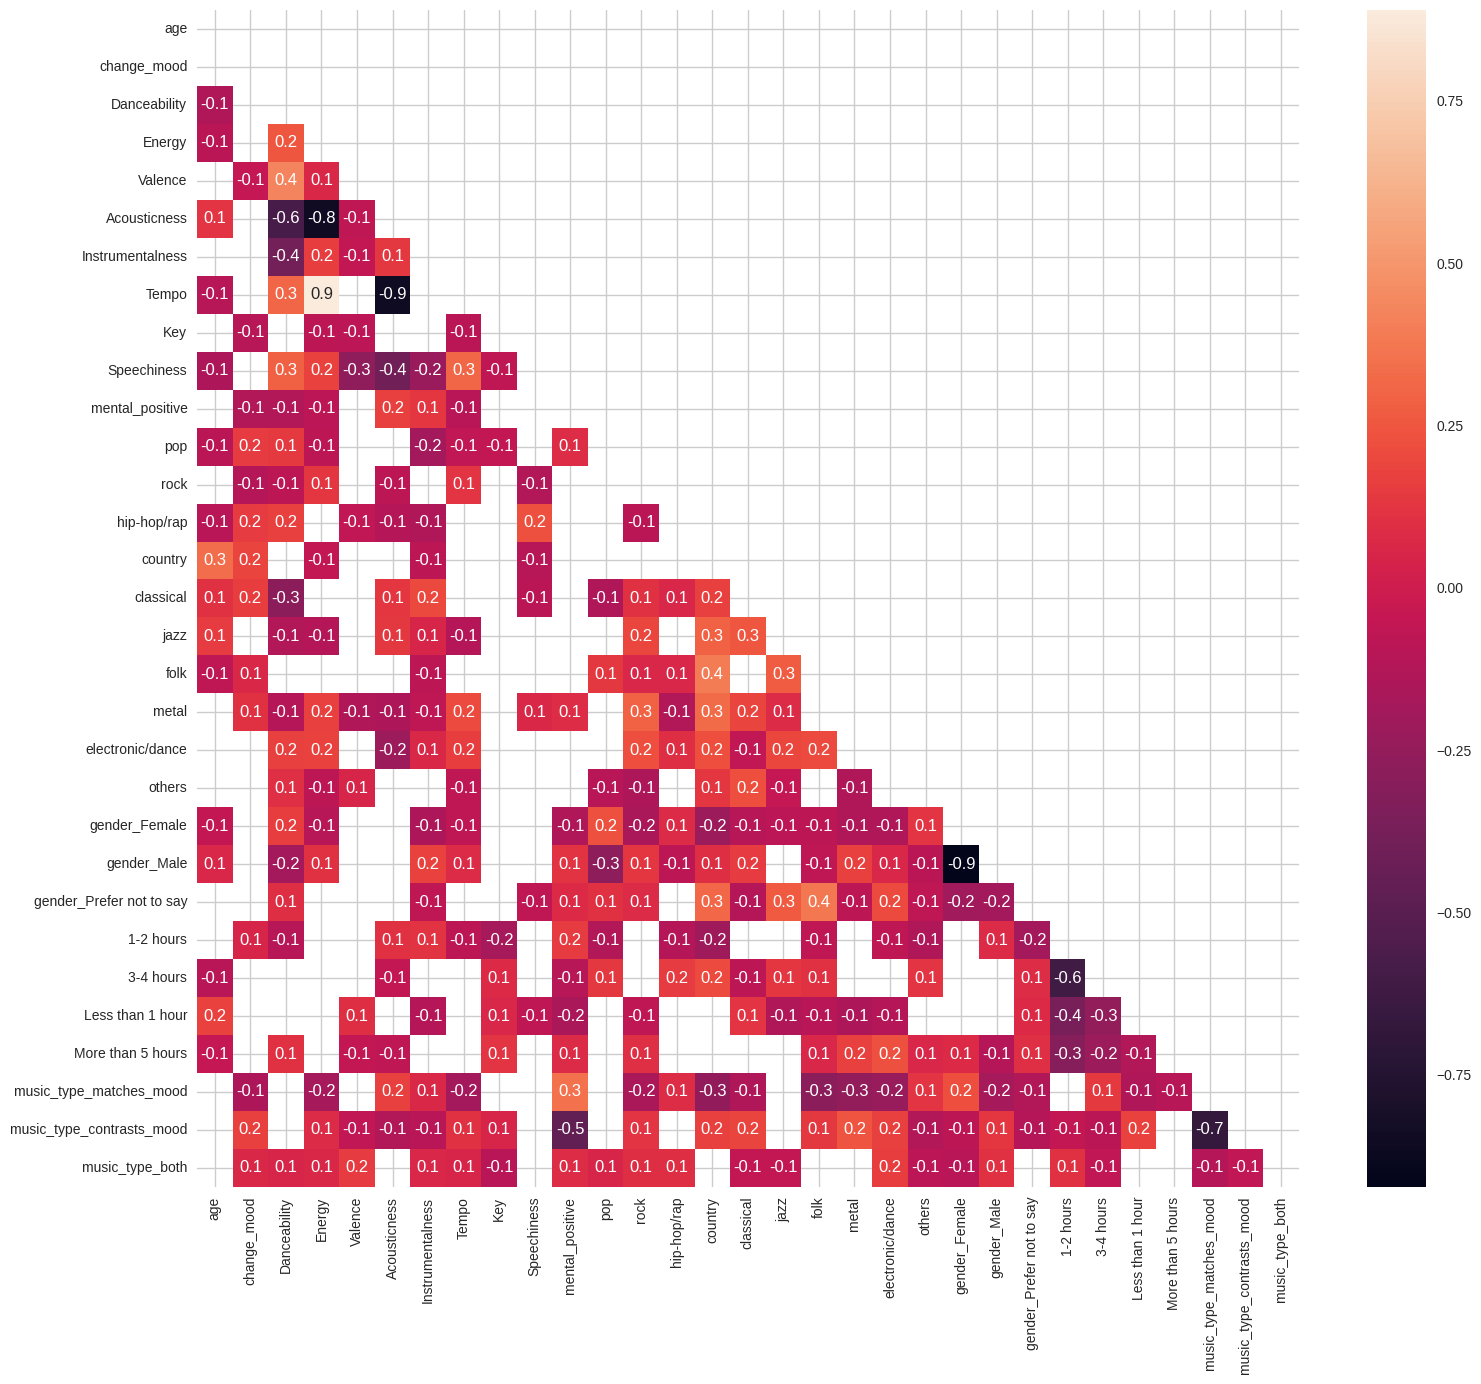

In [164]:
df_temp = df.drop(columns=['Song'])
plt.figure(figsize=(16, 14))  # Much larger figure size
sns.heatmap(df_temp.corr(),annot=True,fmt='.1f',mask = np.triu(np.ones_like(df_temp.corr(), dtype=bool))|(abs(df_temp.corr())<0.05))
plt.tight_layout()

In [165]:
target = np.array(df.mental_positive)
x = df.drop(columns=['mental_positive','Song'])

In [166]:
x.columns

Index(['age', 'change_mood', 'Danceability', 'Energy', 'Valence',
       'Acousticness', 'Instrumentalness', 'Tempo', 'Key', 'Speechiness',
       'pop', 'rock', 'hip-hop/rap', 'country', 'classical', 'jazz', 'folk',
       'metal', 'electronic/dance', 'others', 'gender_Female', 'gender_Male',
       'gender_Prefer not to say', '1-2 hours', '3-4 hours',
       'Less than 1 hour', 'More than 5 hours', 'music_type_matches_mood',
       'music_type_contrasts_mood', 'music_type_both'],
      dtype='object')

# Decision Tree Classifier


In [167]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target, random_state=42)

In [168]:
scaler=MinMaxScaler()
scaler.fit(X_train)
x_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

In [169]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(5)
param_val = [{'criterion':['entropy','gini'],'max_depth':[0,10],'min_samples_split':np.arange(2,10,2)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [0, 10],
                          'min_samples_split': array([2, 4, 6, 8])}],
             scoring='roc_auc_ovr')

In [170]:
print(grid.best_score_)
print(grid.best_params_)

0.7464591503267974
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': np.int64(8)}


In [171]:
y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)
metrics.roc_auc_score(y_test,y_pred_2,multi_class='ovr')

np.float64(0.7914979757085021)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


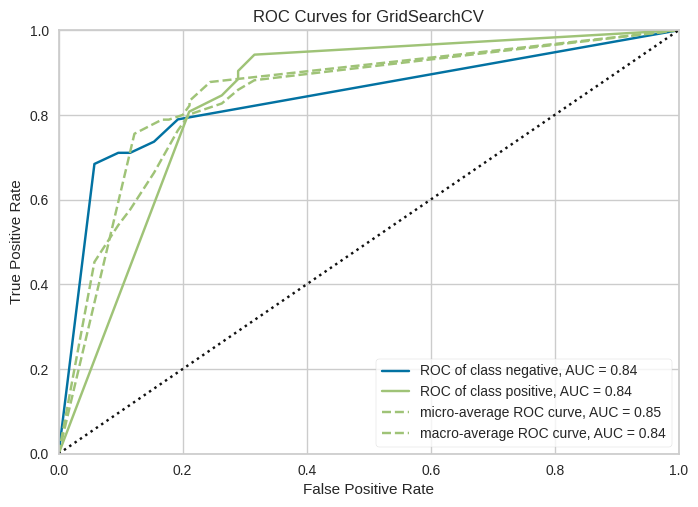

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [172]:
visualizer = ROCAUC(grid, classes=['negative', 'positive'])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()

In [173]:
dt_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_split=int(np.int64(8)),  # Ensure conversion to standard int
    random_state=100
)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=8, random_state=100)

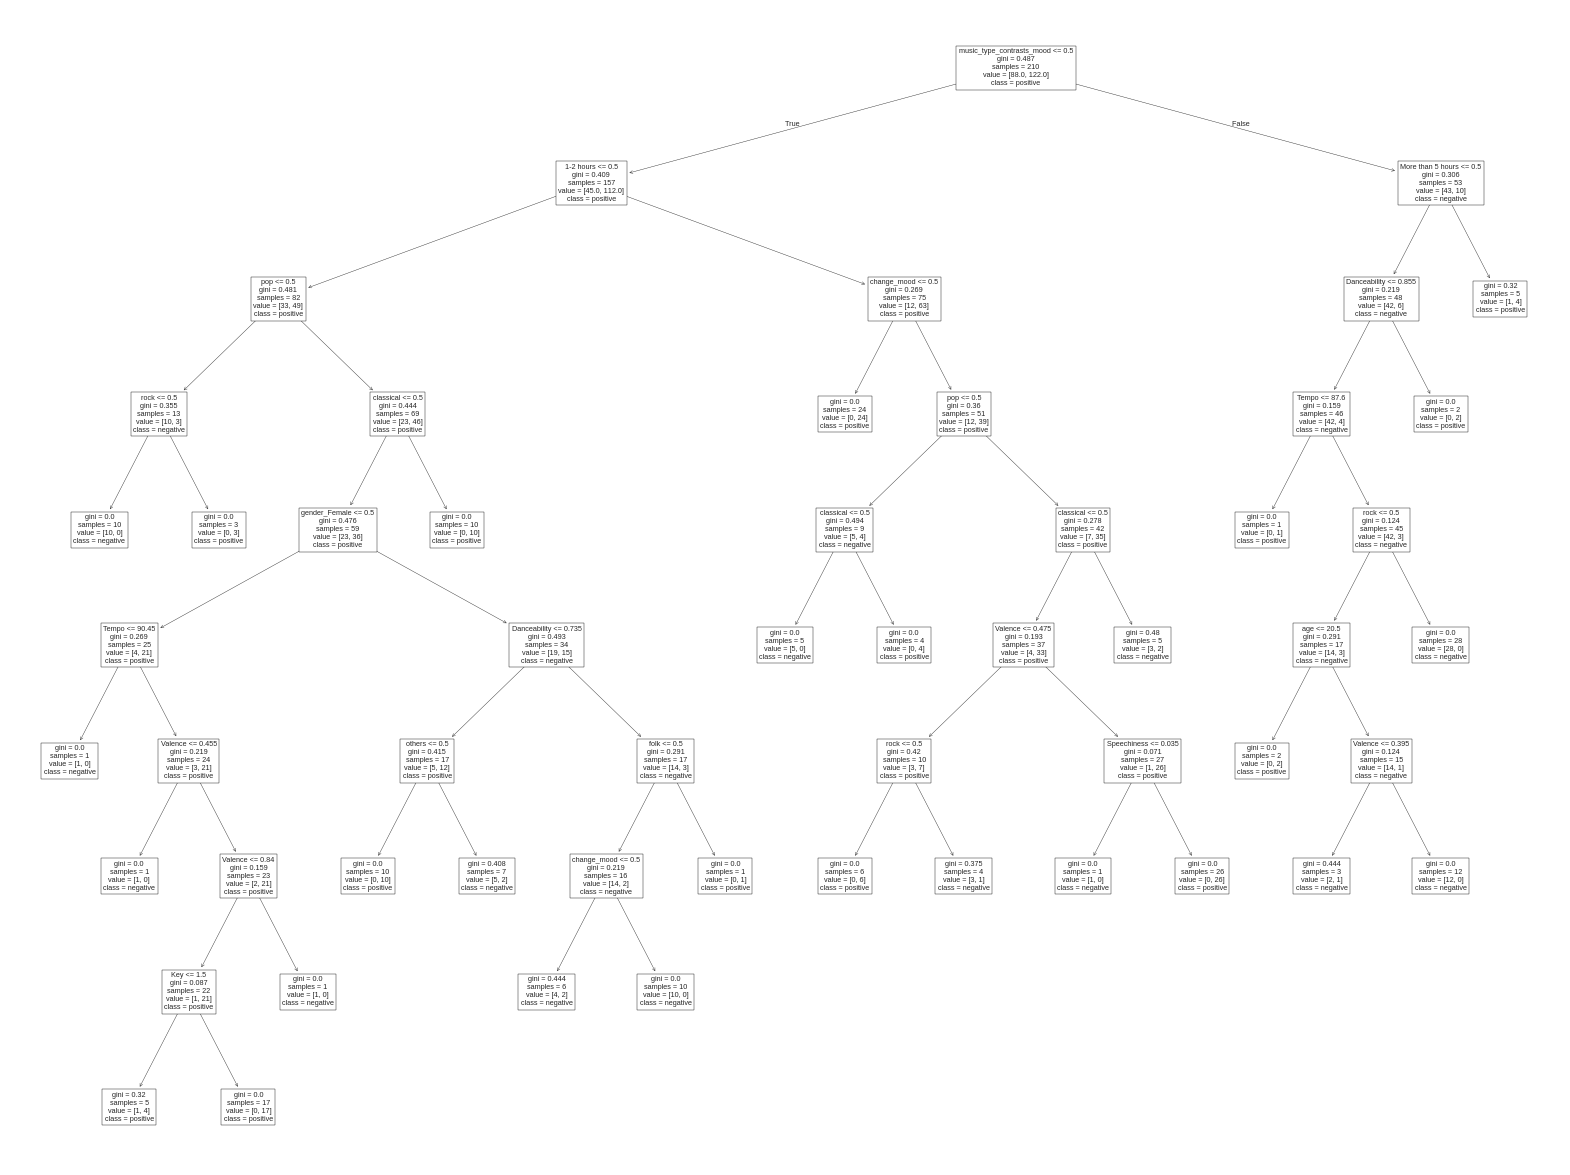

In [174]:
plt.figure(figsize=(20, 15))
plot_tree(dt_clf,feature_names=X_test.columns,class_names=['negative', 'positive'])
plt.show()

In [175]:
y_pred = dt_clf.predict(x_test)

print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44        38
           1       0.62      0.71      0.66        52

    accuracy                           0.58        90
   macro avg       0.56      0.55      0.55        90
weighted avg       0.57      0.58      0.57        90



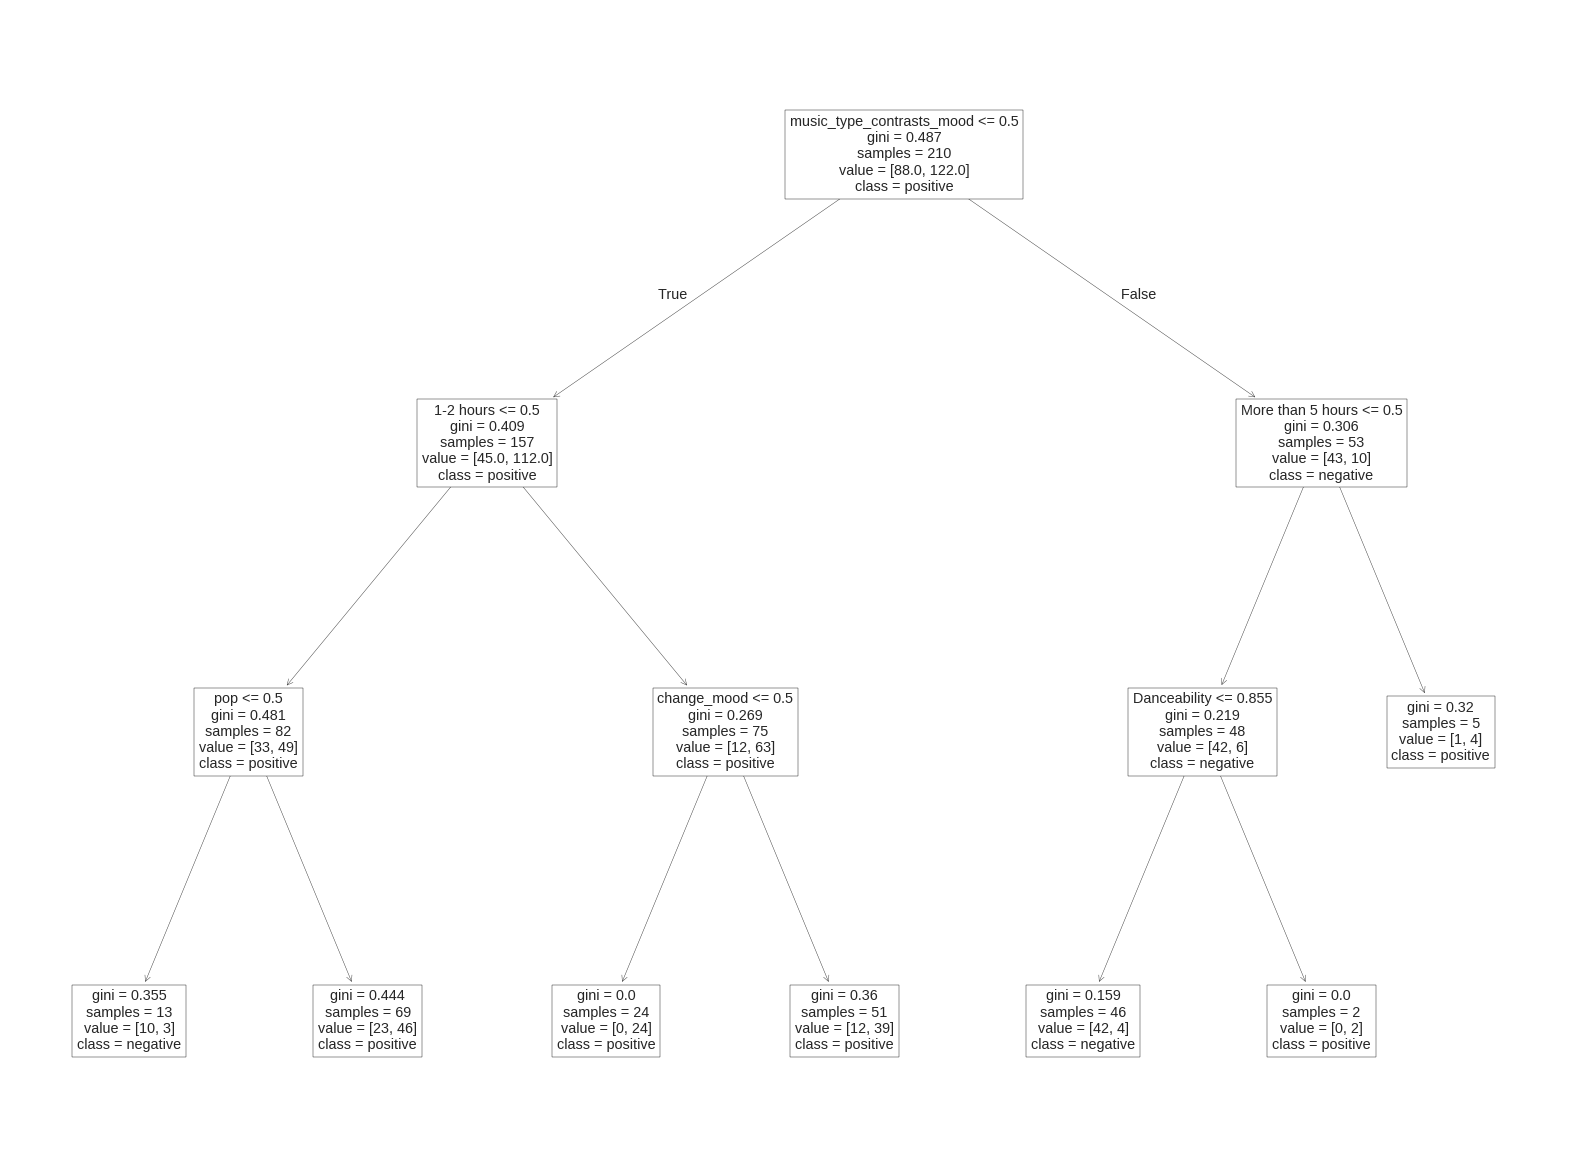

In [176]:
plt.figure(figsize=(20, 15))
# Create a new decision tree with limited depth for visualization
dt_viz = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,  # Limit to 3 levels for better visualization
    min_samples_split=int(np.int64(8)),
    random_state=100
)
dt_viz.fit(X_train, y_train)
plot_tree(dt_viz, feature_names=X_test.columns, class_names=['negative', 'positive'])
plt.show()

In [177]:
dt_clf.get_depth()

9

# Logistic

In [178]:
from sklearn.linear_model import LogisticRegression

### deal with imbalanced data

In [179]:
(df['mental_positive'] ==1).sum(), (df['mental_positive'] ==0).sum()

(np.int64(174), np.int64(126))

In [180]:
from sklearn.utils import resample

df_positive = df[df['mental_positive'] == 1] #majority class
df_negative = df[df['mental_positive'] == 0]

df_downsampled = resample(df_positive,
                                 replace=False,    # sample without replacement
                                 n_samples=84,     # to match minority class
                                 random_state=42)

df_balanced = pd.concat([df_downsampled, df_negative])

In [181]:
(df_balanced['mental_positive'] ==1).sum(), (df_balanced['mental_positive'] ==0).sum()

(np.int64(84), np.int64(126))

In [182]:
balanced_target = np.array(df_balanced.mental_positive)
balanced_x = df_balanced.drop(columns=['mental_positive','Song'])

### preprocess

In [183]:
X_train, X_test, y_train, y_test = train_test_split(balanced_x, balanced_target, test_size=0.3,shuffle=True,stratify=balanced_target)

In [184]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

In [185]:
X_train.iloc[:,:19].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,age,change_mood,Danceability,Energy,Valence,Acousticness,Instrumentalness,Tempo,Key,Speechiness,pop,rock,hip-hop/rap,country,classical,jazz,folk,metal,electronic/dance
age,1.0,,,,,,,,,,,,,,,,,,
change_mood,,1.0,,,,,,,,,,,,,,,,,
Danceability,,,1.0,,,,,,,,,,,,,,,,
Energy,,,,1.0,,-0.84,,0.91,,,,,,,,,,,
Valence,,,,,1.0,,,,,,,,,,,,,,
Acousticness,,,,-0.84,,1.0,,-0.87,,,,,,,,,,,
Instrumentalness,,,,,,,1.0,,,,,,,,,,,,
Tempo,,,,0.91,,-0.87,,1.0,,,,,,,,,,,
Key,,,,,,,,,1.0,,,,,,,,,,
Speechiness,,,,,,,,,,1.0,,,,,,,,,


In [186]:
X_train.iloc[:,10:].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,pop,rock,hip-hop/rap,country,classical,jazz,folk,metal,electronic/dance,others,gender_Female,gender_Male,gender_Prefer not to say,1-2 hours,3-4 hours,Less than 1 hour,More than 5 hours,music_type_matches_mood,music_type_contrasts_mood,music_type_both
pop,1.0,,,,,,,,,,,,,,,,,,,
rock,,1.0,,,,,,,,,,,,,,,,,,
hip-hop/rap,,,1.0,,,,,,,,,,,,,,,,,
country,,,,1.0,,,,,,,,,,,,,,,,
classical,,,,,1.0,,,,,,,,,,,,,,,
jazz,,,,,,1.0,,,,,,,,,,,,,,
folk,,,,,,,1.0,,,,,,,,,,,,,
metal,,,,,,,,1.0,,,,,,,,,,,,
electronic/dance,,,,,,,,,1.0,,,,,,,,,,,
others,,,,,,,,,,1.0,,,,,,,,,,


In [187]:
# Drop features with high correlation
X_train = X_train.drop(columns=['Tempo','Acousticness'])

### model

In [188]:
lrc=LogisticRegression( multi_class='ovr',solver='saga',random_state=100)

#Train the model using the training sets
lrc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_test = lrc.predict(X_test.drop(columns=['Tempo','Acousticness']))
y_pred_train = lrc.predict(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report: 
               precision    recall  f1-score   support

    negative       0.87      0.87      0.87        38
    positive       0.80      0.80      0.80        25

    accuracy                           0.84        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.84      0.84      0.84        63
 

Accuracy on train:   0.8231292517006803 

Accuracy on test:  0.8412698412698413 



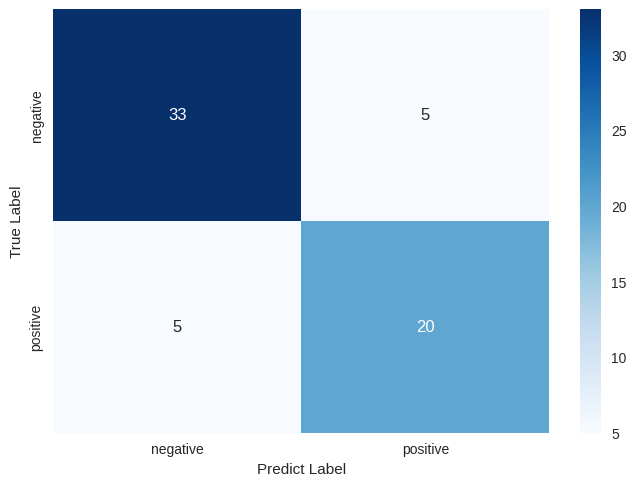

In [189]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred_test,target_names=['negative', 'positive']),'\n')
print("Accuracy on train:  ",lrc.score(X_train,y_train),'\n')
print("Accuracy on test: ",lrc.score(X_test.drop(columns=['Tempo','Acousticness']),y_test),'\n')
cf=metrics.confusion_matrix(y_test,y_pred_test)
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

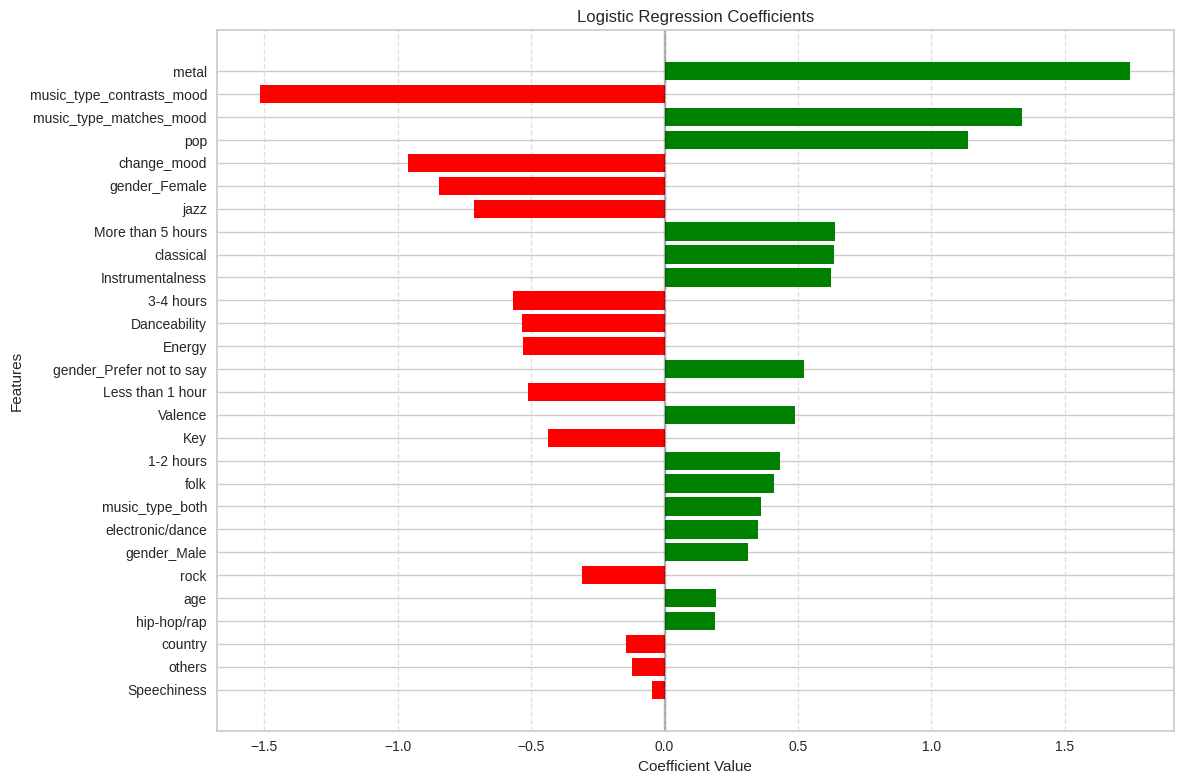

In [190]:
# Plot the coefficients of the logistic regression model
plt.figure(figsize=(12, 8))

# Get feature names and coefficients
feature_names = X_train.columns
coefficients = lrc.coef_[0]

# Sort coefficients by absolute value for better visualization
indices = np.argsort(np.abs(coefficients))
sorted_feature_names = np.array(feature_names)[indices]
sorted_coefficients = coefficients[indices]

# Create horizontal bar plot
plt.barh(sorted_feature_names, sorted_coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Color positive and negative coefficients differently
colors = ['red' if c < 0 else 'green' for c in sorted_coefficients]
plt.barh(sorted_feature_names, sorted_coefficients, color=colors)

plt.tight_layout()
plt.show()


# KNN

In [191]:
from sklearn.neighbors import KNeighborsClassifier

In [207]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target)

In [208]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [209]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.73      0.85      0.79        52

    accuracy                           0.73        90
   macro avg       0.73      0.71      0.72        90
weighted avg       0.73      0.73      0.73        90
 

Accuracy:  0.7333333333333333 



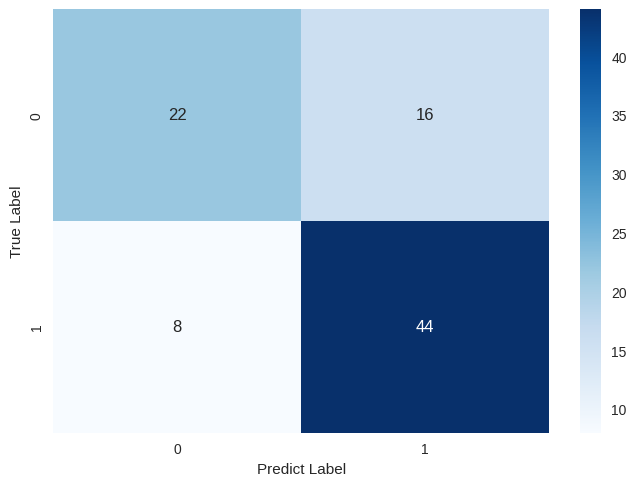

In [210]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Classification Report: \n", metrics.classification_report(y_test,y_pred),'\n')
print("Accuracy: ",metrics.accuracy_score(y_test,y_pred),'\n')
cf=metrics.confusion_matrix(y_test,y_pred).round(3)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


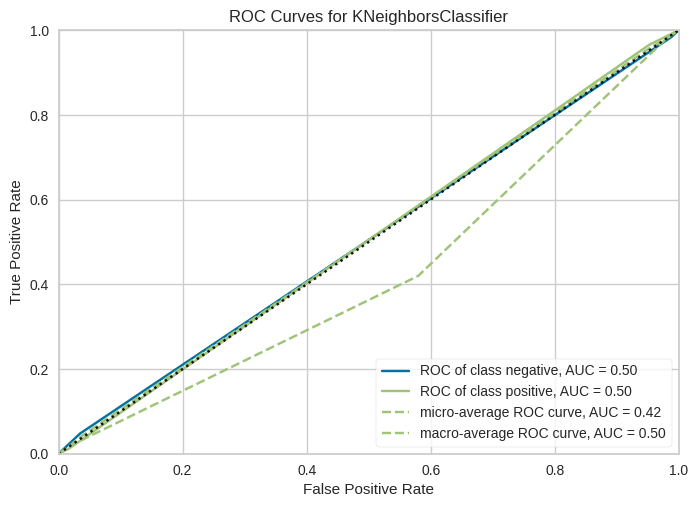

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [196]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(knn, classes=['negative','positive'])
visualizer.fit(x, target)        # Fit the training data to the visualizer
visualizer.score(x,target)        # Evaluate the model on the test data
visualizer.show()

## Neural Network

In [197]:
# First split into train and temp (temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(x, target, test_size=0.3, shuffle=True, stratify=target)

# Split temp into validation and test sets (50% of temp each, which is 15% of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp)

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
X_val=pd.DataFrame(scaler.transform(X_val),columns=x.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=20
Validation Accuracy: 0.8667, AUC: 0.8988
Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=30
Validation Accuracy: 0.7333, AUC: 0.8745
Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=50
Validation Accuracy: 0.5333, AUC: 0.5921
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=20
Validation Accuracy: 0.8444, AUC: 0.8462
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=30
Validation Accuracy: 0.8222, AUC: 0.8826
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=50
Validation Accuracy: 0.8000, AUC: 0.8785
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=20
Validation Accuracy: 0.8889, AUC: 0.9291
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=30
Validation Accuracy: 0.9333, AUC: 0.9919
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=50
Validation Accuracy: 0.9111, AUC: 0.9818
Training with: batch_size=16, hidden_siz

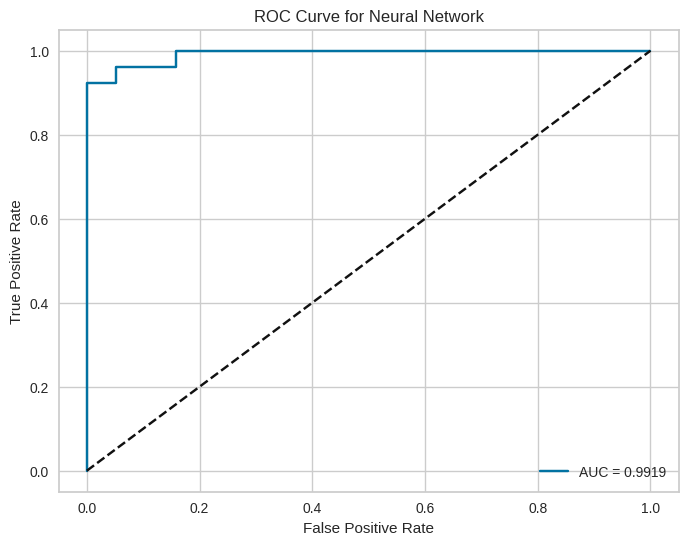

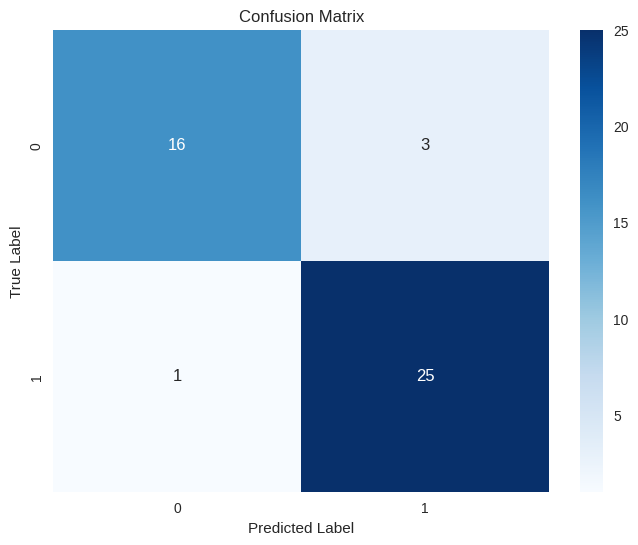

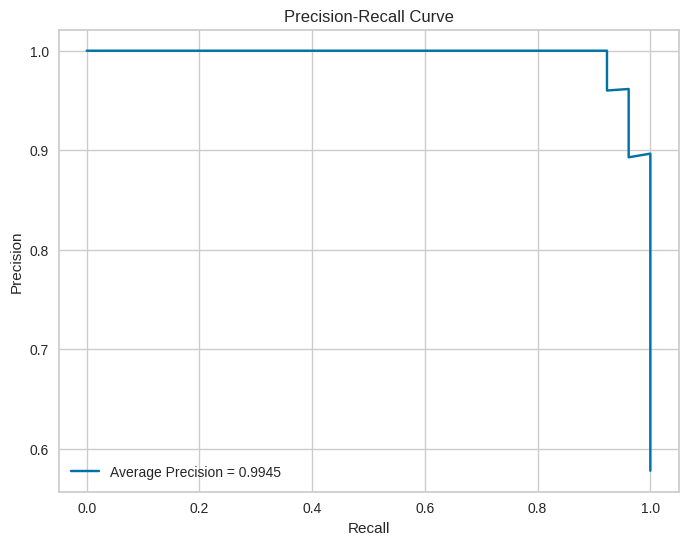

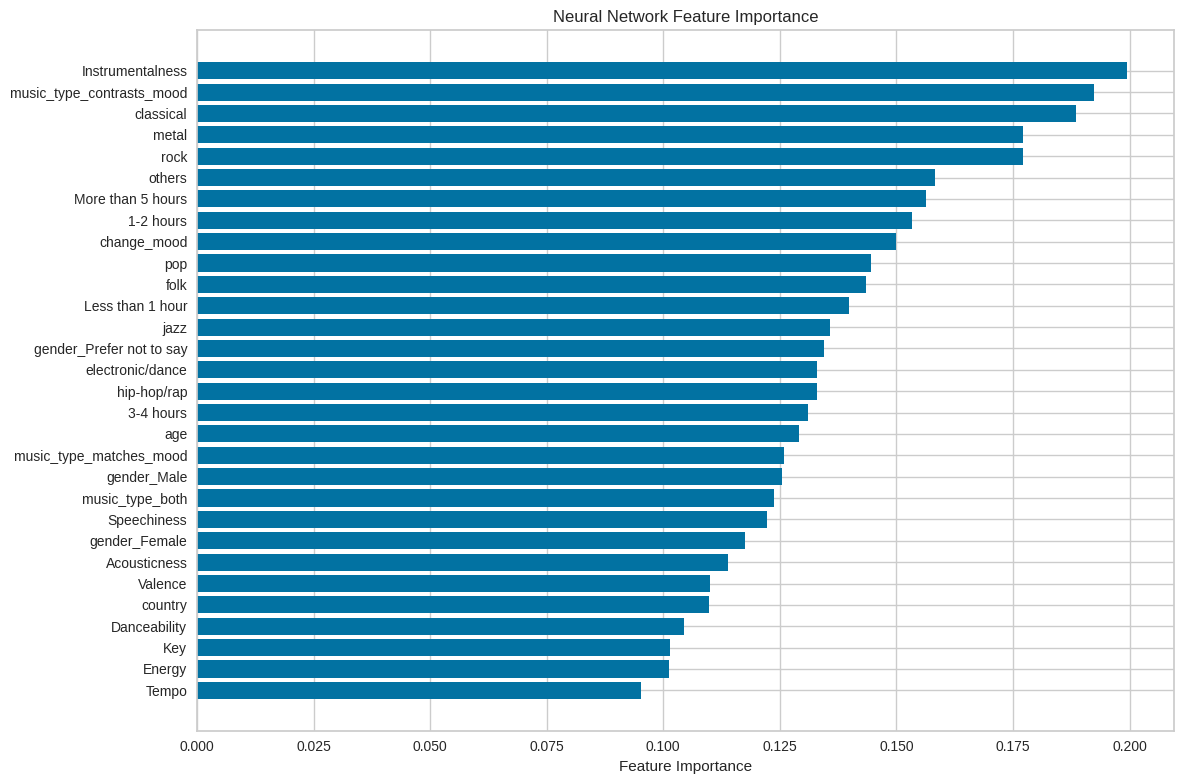

In [198]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Neural network model
class MoodClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2):
        super(MoodClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, x):
        return self.model(x)

# Grid search parameters
param_grid = {
    'batch_size': [16, 32],
    'hidden_size': [32, 64, 128, 256],
    'learning_rate': [0.05, 0.001, 0.005],
    'epochs': [20, 30, 50]
}

# Function to train and evaluate model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float('inf')
    best_model_state = model.state_dict().copy()

    for epoch in range(epochs):
        # Training
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    # Load best model
    model.load_state_dict(best_model_state)
    return model

# Perform grid search
results = []
input_size = X_train.shape[1]

for batch_size in param_grid['batch_size']:
    for hidden_size in param_grid['hidden_size']:
        for lr in param_grid['learning_rate']:
            for num_epochs in param_grid['epochs']:
                print(f"Training with: batch_size={batch_size}, hidden_size={hidden_size}, lr={lr}, epochs={num_epochs}")

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size)

                model = MoodClassifier(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size//2)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=num_epochs)

                # Evaluate on validation set
                model.eval()
                all_preds = []
                all_probs = []
                all_labels = []

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        probs = torch.softmax(outputs, dim=1)[:, 1]

                        all_preds.extend(preds.numpy())
                        all_probs.extend(probs.numpy())
                        all_labels.extend(labels.numpy())

                val_accuracy = accuracy_score(all_labels, all_preds)
                val_auc = roc_auc_score(all_labels, all_probs)

                results.append({
                    'batch_size': batch_size,
                    'hidden_size': hidden_size,
                    'learning_rate': lr,
                    'epochs': num_epochs,
                    'val_accuracy': val_accuracy,
                    'val_auc': val_auc,
                    'model': model
                })

                print(f"Validation Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")

# Find best model
best_result = max(results, key=lambda x: x['val_accuracy'])
best_model = best_result['model']
print(f"\nBest Model: batch_size={best_result['batch_size']}, hidden_size={best_result['hidden_size']}, learning_rate={best_result['learning_rate']}, epochs={best_result['epochs']}, val_auc={best_result['val_auc']:.4f}")

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=best_result['batch_size'])
best_model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        test_preds.extend(preds.numpy())
        test_probs.extend(probs.numpy())
        test_labels.extend(labels.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)
print(f"Test Accuracy: {test_accuracy:.4f}, AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
avg_precision = average_precision_score(test_labels, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance using model weights (for the first layer)
feature_names = x.columns
weights = best_model.model[0].weight.data.numpy() if hasattr(best_model, 'model') else np.ones((1, len(feature_names)))
importance = np.abs(weights).mean(axis=0)
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Neural Network Feature Importance')
plt.tight_layout()
plt.show()